In [2]:
import os
os.chdir('/content/drive/MyDrive/viact')
!ls

image  output  train.json


In [3]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

     |████████████████████████████████| 276kB 17.4MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44074 sha256=f3ae6c70d32943336099936d6df0f107173054e6042d2801e06d44a2f892d835
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.8.1+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [4]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.8)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes its default version
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
     |████████████████████████████████| 6.2MB 594kB/s 
     |████████████████████████████████| 51kB 6.4MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.3.post20210317-cp37-none-any.whl size=58543 sha256=3cebfed882e447cf41d67681bc7244e89d81c854551122e56848634cf4f441f8
  Stored in directory: /root/.cache/pip/wheels/d2/ee/3a/5c531df777c03d8c67f22c65f97d6f75321087482d05a9b218
Successfully built fvcore


In [5]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
# import some common libraries
import numpy as np
import cv2
import random
import os
import torch

from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
import copy

from detectron2.engine import DefaultTrainer
from detectron2.data import build_detection_test_loader, build_detection_train_loader

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog
from detectron2.data import DatasetMapper
from detectron2.data.datasets import register_coco_instances

In [6]:
register_coco_instances("qi_train", {}, "/content/drive/MyDrive/viact/train.json", "/content/drive/MyDrive/viact/image")

In [7]:
from detectron2.data.catalog import DatasetCatalog
qi_train_metadata = MetadataCatalog.get("qi_train")
dataset_dicts = DatasetCatalog.get("qi_train")

print(qi_train_metadata)

WARNING [04/25 03:54:16 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/25 03:54:16 d2.data.datasets.coco]: Loaded 527 images in COCO format from /content/drive/MyDrive/viact/train.json
Metadata(evaluator_type='coco', image_root='/content/drive/MyDrive/viact/image', json_file='/content/drive/MyDrive/viact/train.json', name='qi_train', thing_classes=['Helmet and Mask present', 'Mask available', 'No Helmet and Mask present', 'Safety Helmet present'], thing_dataset_id_to_contiguous_id={0: 0, 1: 1, 2: 2, 3: 3})


In [32]:
!ls

29.jpg	37.jpg	image  model_final.pth	output	train.json


In [33]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("qi_train",)
cfg.DATASETS.TEST = ("qi_test",)

cfg.MODEL.WEIGHTS = '/content/drive/MyDrive/viact/model_final.pth'
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.MOMENTUM = 0.9
cfg.SOLVER.WEIGHT_DECAY = 0.001

cfg.MODEL.BACKBONE.FREEZE_AT = 2

cfg.SOLVER.WARMUP_FACTOR = 1.0/1000
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 10000 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05
cfg.SOLVER.CHECKPOINT_PERIOD = 5000

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4
cfg.MODEL.RPN.POST_NMS_TOPK_TEST = 10000 #added 1
cfg.MODEL.RPN.POST_NMS_TOPK_TEST = 10000 #added 2


In [9]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

In [34]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)+
trainer.train()

[04/25 04:48:57 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

KeyError: ignored

In [57]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

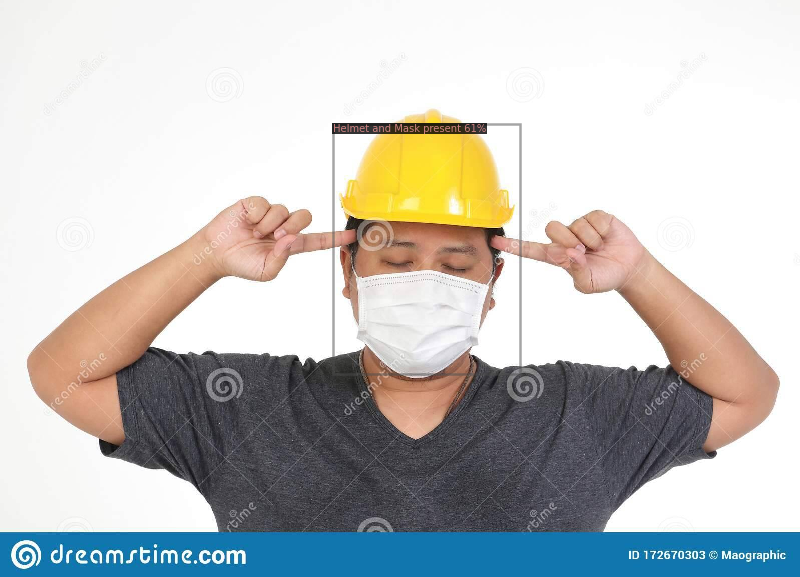

In [58]:
im = cv2.imread('/content/44.jpg')
outputs = predictor(im)
from google.colab.patches import cv2_imshow
v = Visualizer(im[:, :, ::-1],
                   metadata=qi_train_metadata, 
                   scale=0.5   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])